In [53]:
import pandas as pd

# Rest API

In [6]:
import requests

In [135]:

url = "http://api.nobelprize.org/2.1/nobelPrizes"
d = {
    "offset":1,
    "limit": 200,
    "sort":"asc",
    "nobelPrizeYear":1901,
    "yearTo": 2024,
    "nobelPrizeCategory":"phy",
    "format":"json",
    "csvLang":"en"
}

response = requests.get(url, params=d)

data =response.json()
data

{'nobelPrizes': [{'awardYear': '1902',
   'category': {'en': 'Physics', 'no': 'Fysikk', 'se': 'Fysik'},
   'categoryFullName': {'en': 'The Nobel Prize in Physics',
    'no': 'Nobelprisen i fysikk',
    'se': 'Nobelpriset i fysik'},
   'dateAwarded': '1902-11-11',
   'prizeAmount': 141847,
   'prizeAmountAdjusted': 9129789,
   'links': [{'rel': 'nobelPrize',
     'href': 'https://api.nobelprize.org/2/nobelPrize/phy/1902',
     'action': 'GET',
     'types': 'application/json'}],
   'laureates': [{'id': '2',
     'knownName': {'en': 'Hendrik A. Lorentz'},
     'fullName': {'en': 'Hendrik Antoon Lorentz'},
     'portion': '1/2',
     'sortOrder': '1',
     'motivation': {'en': 'in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena',
      'se': 'såsom ett erkännande av den utomordentliga förtjänst de inlagt genom sina undersökningar över magnetismens inflytande på strålningsfenomenen'},
     'links': [{'rel':

In [137]:
# Prepare lists to store data 
years = [] 
winners = []
motivations = []

# Extracting data from JSON 
for prize in data["nobelPrizes"]: 
    if "laureates" in prize:
        for laureate in prize["laureates"]: 
            years.append(prize["awardYear"]) 
            winners.append(laureate["fullName"]["en"]) 
            motivations.append(laureate["motivation"]["en"])
        
# Creating DataFrame 
df_physics = pd.DataFrame({ 
    'Year': years, 
    'Winners': winners,
    'Motivations': motivations
})

df_physics

,Year,Winners,Motivations
0,1902,Hendrik Antoon Lorentz,in recognition of the extraordinary service th...
1,1902,Pieter Zeeman,in recognition of the extraordinary service th...
2,1903,Antoine Henri Becquerel,in recognition of the extraordinary services h...
3,1903,Pierre Curie,in recognition of the extraordinary services t...
4,1903,"Marie Curie, née Skłodowska",in recognition of the extraordinary services t...
...,...,...,...
221,2023,Pierre Agostini,for experimental methods that generate attosec...
222,2023,Ferenc Krausz,for experimental methods that generate attosec...
223,2023,Anne L’Huillier,for experimental methods that generate attosec...
224,2024,John J. Hopfield,for foundational discoveries and inventions th...


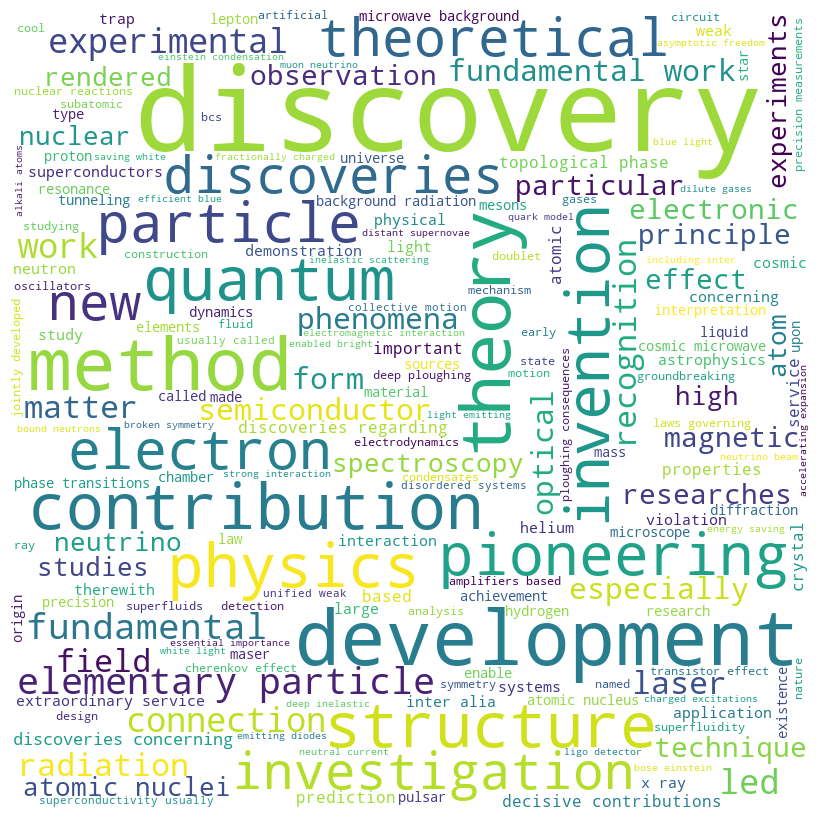

In [152]:
# Word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
# Think about removing stop words and white spaces
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_physics['Motivations']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Web Scraping

In [262]:
import requests 
from bs4 import BeautifulSoup 
import re
import pandas as pd

In [322]:
# Set the base URL 
BASE_URL = "https://books.toscrape.com/catalogue/page-{}.html" 

# Prepare a list to store data 
all_products = [] 
seen_upcs = set()

In [324]:
# All products in <article class="product_pod"> </article>
# product name is under article>h3>a 
# price is under article>div class="product_price" > p class="price_color"

def process_page(url, page_number):
    # Send a request to get the page content 
    res = requests.get(url) 
    html = BeautifulSoup(res.content, 'html.parser')
    # Find all product elements 
    products = html.find_all("article", class_="product_pod") 
    print(f"Found {len(products)} products on page {url}") # Debug output
    # Loop through each product to get detailed information 
    for article in products:
        link_to_subpage = article.find("h3").find("a").get("href")
        # HELA URL
        full_link_to_subpage = "https://books.toscrape.com/catalogue/" + link_to_subpage
        # Send a request to the product's subpage 
        res_sub = requests.get(full_link_to_subpage) 
        html_sub = BeautifulSoup(res_sub.content, 'html.parser')
        # Find UPC information
        table = html_sub.find_all("table", attrs={"class": "table table-striped"})[0] # find_all -> lista 
        trs = table.find_all("tr") 
        ## Loop through table rows
        for tr in trs:
            name = tr.find("th").get_text()
            value = tr.find("td").get_text()
            if (name == "UPC"):
                product_upc = value
        # If the product UPC is already seen, skip it 
        if product_upc in seen_upcs: 
            continue 
        # Mark this UPC as seen 
        seen_upcs.add(product_upc)
        
        # Extract product name 
        product_name = article.find("h3").find("a").get("title") 
        # Extract product price 
        product_price = article.find("div", class_="product_price").find("p", class_="price_color").get_text() 
        # Extract product rating 
        product_rating = article.find("p", class_=re.compile(r"star-rating"))['class'][1] 
        # Save product information 
        all_products.append({ 
            'UPC': product_upc, 
            'Title': product_name, 
            'Price': product_price, 
            'Rating': product_rating 
        })
    print(f"Collected {len(all_products)} total products so far")


In [330]:
# Loop through multiple pages 
for page in range(1, 4): 
    URL = BASE_URL.format(page) 
    process_page(URL, page)

# Convert the extracted product information to a DataFrame 
df_products = pd.DataFrame(all_products) 



Found 20 products on page https://books.toscrape.com/catalogue/page-1.html
Collected 60 total products so far
Found 20 products on page https://books.toscrape.com/catalogue/page-2.html
Collected 60 total products so far
Found 20 products on page https://books.toscrape.com/catalogue/page-3.html
Collected 60 total products so far


In [334]:
print(f"Total number of products: {len(df_products)}")
# Set the styler for the DataFrame 
styled_df = df_products.style.set_table_styles([ 
    {'selector': 'td, th', 'props': [('text-align', 'center'), ('border', '1px solid black')]}
])
# Display the styled DataFrame 
styled_df

Total number of products: 60


,UPC,Title,Price,Rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
5,f77dbf2323deb740,The Requiem Red,£22.65,One
6,2597b5a345f45e1b,The Dirty Little Secrets of Getting Your Dream Job,£33.34,Four
7,e72a5dfc7e9267b2,"The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull",£17.93,Three
8,e10e1e165dc8be4a,The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics,£22.60,Four
9,1dfe412b8ac00530,The Black Maria,£52.15,One
